In [1]:
import utils
from utils import *
from keras.applications.resnet50 import *
from keras.preprocessing import image
from keras.preprocessing.image import *

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from image_90rotations import *
# from ImageDataGenerator_extended2 import *



%matplotlib inline
from sys import getsizeof
import seaborn as sns

Using TensorFlow backend.


In [2]:
target_size = (200,200)#(256, 256)

In [3]:
K.image_data_format()

'channels_last'

### Load Data

In [4]:
x_train = []
y_train = []

df_train = pd.read_csv('data/train_v2.csv')
df_test = pd.read_csv('data/sample_submission_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

labels = ['blow_down',
 'bare_ground',
 'conventional_mine',
 'blooming',
 'cultivation',
 'artisinal_mine',
 'haze',
 'primary',
 'slash_burn',
 'habitation',
 'clear',
 'road',
 'selective_logging',
 'partly_cloudy',
 'agriculture',
 'water',
 'cloudy']

label_map = {'agriculture': 14,
 'artisinal_mine': 5,
 'bare_ground': 1,
 'blooming': 3,
 'blow_down': 0,
 'clear': 10,
 'cloudy': 16,
 'conventional_mine': 2,
 'cultivation': 4,
 'habitation': 9,
 'haze': 6,
 'partly_cloudy': 13,
 'primary': 7,
 'road': 11,
 'selective_logging': 12,
 'slash_burn': 8,
 'water': 15}

### Load JPEG files

In [5]:
# x_train = np.zeros((df_train.shape[0],target_size[0],target_size[0],3)).astype(np.float32)

# c=0
# # loading images the keras way
# for f, tags in tqdm_notebook(df_train.values, miniters=1000):
    
#     img = image.load_img('data/train-jpg/{}.jpg'.format(f), target_size=target_size)
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)

#     x_train[c] = x
#     c +=1    



In [6]:
# save_array("data/cache/xtrain_100x100.dat",x_train)
# save_array("data/cache/xtest_100x100.dat",x_test)
# save_array("data/cache/ytrain.dat",y_train)

# save_array("data/cache/xtrain_{}x{}.dat".format(target_size[0],target_size[0]),x_train)
# save_array("data/cache/xtest_{}x{}.dat".format(target_size[0],target_size[0]),x_test)


In [5]:
x_train = load_array("data/cache/xtrain_{}x{}.dat".format(target_size[0],target_size[1]))
y_train = load_array("data/cache/ytrain.dat")



In [7]:
# x_train = x_train.transpose(0,3,1,2)

In [8]:
# x_test = load_array("data/cache/xtest_100x100.dat")


In [9]:
print(x_train.shape)
# print(x_test.shape)
print(y_train.shape)


(40479, 200, 200, 3)
(40479, 17)


making a holdout set

In [6]:
VALIDATION_SPLIT = 0.2
np.random.seed(3)

# perm = np.random.permutation(len(x_sample))
# idx_train = perm[:int(len(x_sample)*(1-VALIDATION_SPLIT))]
# idx_val = perm[int(len(x_sample)*(1-VALIDATION_SPLIT)):]

# X_train = x_sample[idx_train]
# Y_train = y_sample[idx_train]
# X_valid = x_sample[idx_val]
# Y_valid = y_sample[idx_val]



perm = np.random.permutation(len(x_train))
idx_train = perm[:int(len(x_train)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(x_train)*(1-VALIDATION_SPLIT)):]


X_train = x_train[idx_train]
Y_train = y_train[idx_train]


X_valid = x_train[idx_val]
Y_valid = y_train[idx_val]

del x_train


# X_sample = X_train[:len(X_train)//2]
# Y_sample = Y_train[:len(Y_train)//2]


#### Loading test  data

In [66]:
# x_test = np.memmap("data/cache/xtest_{}x{}.memmapped".format(target_size[0],target_size[0]), dtype='float32', mode='r', 
#                        shape=(df_test.shape[0],target_size[0],target_size[0],3))

In [14]:
### Test data
# c = 0
# for f, tags in tqdm_notebook(df_test.values, miniters=1000):
    
#     img = image.load_img('data/test-jpg/{}.jpg'.format(f), target_size=target_size)
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)

#     x_test[c] = x
#     c +=1
        


### Model Training 


In [7]:
resnet = ResNet50(include_top=False, input_shape=(target_size[0], target_size[0],3))


In [8]:
for layer in resnet.layers:
    layer.trainable = False

In [13]:
# resnet.summary()

In [14]:
resnet.layers[-168].name

'bn2a_branch2a'

In [15]:
for i in range(-95,0):
    # 4a: -95
    # tuning 5b: -21
    # tuning branch 5c -11
    # tuning from 5a: -33
    resnet.layers[i].trainable = True

In [9]:
x = Flatten()(resnet.layers[-1].output)
x = Dropout(0.5)(x)

x = Dense(1024, activation='relu')(x)

x = Dropout(0.5)(x)

x = Dense(17,activation='sigmoid',name="fc17")(x)



In [11]:
model = Model(inputs=resnet.input,outputs=x)
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights("weights/resnet_augv2_17class_4a.h5")

# 0.0909 resnet_17class_aug_real5b_sample
# 0.1003 resnet_augv2_17class_toponly
# 0.087 resnet_augv2_17class_4a

In [22]:
model.layers[-3].name

'dense_1'

In [26]:
resnet_features_model = Model(inputs=resnet.input,outputs=model.layers[-3].output)

In [42]:
# for l in model.layers:
#     if l.trainable==True:
#         print (l.name)

#### With Augmentation

In [ ]:
y_test = load_array('data/cache/preds_resnet4a_12xtta_bugfixed.dat/')

In [60]:
class MixIterator(Iterator):
    
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list
        self.N = len(X_train)
#         if self.multi:
#             self.N = sum([it[0].N for it in self.iters])
#         else:
#             self.N = sum([it.N for it in self.iters])
        super(MixIterator, self).__init__(X_train.shape[0], 128, True, seed=None)

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):
#         if self.multi:
#             nexts = [[next(it) for it in o] for o in self.iters]
#             n0s = np.concatenate([n[0] for n in o])
#             n1s = np.concatenate([n[1] for n in o])
#             return (n0, n1)
#         else:
        nexts = [next(it) for it in self.iters]
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)

In [12]:
batch_size = 128

train_gen = ImageDataGenerator2(rotation_range=270,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    shear_range=0.1,
#     zoom_range=0.2,
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

#,fill_mode='reflect'


# train_batch = train_gen.flow(x_train,y_train,batch_size=96,shuffle=True)

train_batch = train_gen.flow(X_train,Y_train,batch_size=96,shuffle=True)
# valid_batch = train_gen.flow(X_valid,Y_valid,batch_size=20,shuffle=True)
# test_batch = train_gen.flow(x_test,y_test,batch_size=32,shuffle=True)

In [61]:
mi = MixIterator([train_batch,test_batch])


In [62]:
mi.next()[0].shape

(128, 200, 200, 3)

In [31]:
# t  = train_batch.next()

In [38]:
# plt.imshow(t[0][40])

--- 


In [52]:

kfold_weights_path = os.path.join('weights/', 'resnet_augv2_17class_4a_pseudo.h5')


callbacks = [EarlyStopping(monitor='val_loss', patience=6),
             ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss',  patience=2, verbose=1, factor=0.5, min_lr=1e-6)
            ]



### new augmentation 

top only full data:
Epoch 34/100
253/252 [==============================] - 331s - loss: 0.1074 - acc: 0.9588 - val_loss: 0.1003 - val_acc: 0.9613


5a full:
253/252 [==============================] - 416s - loss: 0.0848 - acc: 0.9670 - val_loss: 0.0900 - val_acc: 0.9655


4a full:
253/252 [==============================] - 559s - loss: 0.0818 - acc: 0.9682 - val_loss: 0.0872 - val_acc: 0.9663


extra aug vresnet_augv2_17class_4a_extra_aug

253/252 [==============================] - 558s - loss: 0.0918 - acc: 0.9657 - val_loss: 0.0907 - val_acc: 0.9655


pseudo labeling

253/252 [==============================] - 568s - loss: 0.0844 - acc: 0.7262 - val_loss: 0.0869 - val_acc: 0.9666



In [20]:
# history = model.fit_generator(mi, validation_data=(X_valid, Y_valid),
#                                steps_per_epoch=len(X_train)/batch_size,epochs=100,callbacks=callbacks)


#### verifying results

In [27]:
if os.path.isfile(kfold_weights_path):
    print ("loading best weights from '{}'".format(kfold_weights_path))
    model.load_weights(kfold_weights_path)
    
    

loading best weights from 'weights/resnet_augv2_17class_4a.h5'


In [13]:
def make_augmented_predictions(model,data,generator,num_aug,ouput_shape=17):
    preds = np.zeros((data.shape[0],ouput_shape)).astype(np.float32) #model.predict(data)
    
    for i in tqdm_notebook(range(num_aug)):
        partial_preds = []
        test_batch = train_gen.flow(data,batch_size=100,shuffle=False)
        partial_preds.append( model.predict_generator(test_batch,steps=data.shape[0]/100, verbose=1))
                             
        preds += np.vstack(partial_preds)
        
    return  preds/float(num_aug)

In [14]:
preds_val = make_augmented_predictions(model,X_valid,train_gen,10)


81/80 [==============================] - 76s    



In [15]:
save_array("data/cache/preds_val_resnet_17class_ft4a_10xaug.dat",preds_val)

In [33]:
resnet_val_features = make_augmented_predictions(resnet_features_model,X_valid,train_gen,10,1024)



81/80 [==============================] - 77s    



In [34]:
save_array("data/cache/resnet_val_features.dat",resnet_val_features)

In [35]:
resnet_train_features = make_augmented_predictions(resnet_features_model,X_train,train_gen,10,1024)


324/323 [==============================] - 307s   



In [36]:
save_array("data/cache/resnet_train_features.dat",resnet_train_features)

In [16]:
def optimise_f2_thresholds2(y, p, verbose=True, resolution=100,num_classes=17):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(num_classes):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.1]*num_classes
    for i in range(num_classes):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            threshold = float(i2) / resolution
            x[i] = threshold
            score = mf(x)
            if score > best_score:
                best_i2 = threshold
                best_score = score

        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    return x


In [17]:
# thres = optimise_f2_thresholds2(Y_valid[:,rare_class_indices], preds_val[1],num_classes=17)
thres = optimise_f2_thresholds2(Y_valid, preds_val,num_classes=17)

np.mean(thres)

0 0.29 0.916802133405
1 0.19 0.917376798601
2 0.13 0.917406676608
3 0.31 0.918031507211
4 0.22 0.920458716096
5 0.16 0.920473924433
6 0.19 0.921390281483
7 0.22 0.922088232292
8 0.34 0.922515533548
9 0.24 0.923895918588
10 0.17 0.924347747093
11 0.27 0.926170397551
12 0.17 0.926411071547
13 0.17 0.926634916237
14 0.25 0.928286105882
15 0.2 0.930269713739


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


16 0.11 0.93031328073


0.21352941176470591

##### Results
only top: ('F2 Score:', 0.90277204908226472)

17x classes 5b: ('F2 Score:', 0.92441155146612664)

17x classes 5a: ('F2 Score:', 0.92602459589916475)


17x classes 4a: F2 Score: 0.930511942105

In [23]:
thres = load_array("data/cache/thresholds_resnet_ft4a_12xaug.dat")

In [24]:
print('F2 Score:', f2_score(Y_valid, preds_val>thres)) #combined_val_preds

F2 Score: 0.936798155334


In [40]:
save_array("data/cache/thresholds_resnet_ft4a_12xaug.dat",thres)

#### Confusin matrix


                  precision    recall  f1-score   support

        blow_down       0.75      0.38      0.50        16
      bare_ground       0.41      0.51      0.46       190
conventional_mine       0.57      0.63      0.60        19
         blooming       0.31      0.18      0.22        62
      cultivation       0.47      0.72      0.57       877
   artisinal_mine       0.61      0.96      0.75        69
             haze       0.61      0.83      0.70       551
          primary       0.96      1.00      0.98      7484
       slash_burn       0.33      0.03      0.06        33
       habitation       0.66      0.79      0.72       710
            clear       0.93      0.99      0.96      5601
             road       0.76      0.91      0.83      1597
selective_logging       0.38      0.45      0.42        77
    partly_cloudy       0.87      0.97      0.92      1514
      agriculture       0.77      0.93      0.84      2482
            water       0.71      0.88      0.78      1530
           cloudy       0.63      0.98      0.77       430

      avg / total       0.84      0.94      0.89     23242

In [18]:
from sklearn.metrics import classification_report

# print classification_report(Y_valid[:,weather_indices].astype(bool),p,target_names=["cloudy","haze","partly_cloudy","clear"])

In [19]:
print (classification_report(Y_valid.astype(bool),(preds_val>thres),
                            target_names=labels))

                   precision    recall  f1-score   support

        blow_down       0.67      0.38      0.48        16
      bare_ground       0.39      0.53      0.45       190
conventional_mine       0.48      0.68      0.57        19
         blooming       0.30      0.13      0.18        62
      cultivation       0.46      0.73      0.56       877
   artisinal_mine       0.62      0.93      0.74        69
             haze       0.58      0.85      0.69       551
          primary       0.97      1.00      0.98      7484
       slash_burn       0.25      0.09      0.13        33
       habitation       0.62      0.82      0.70       710
            clear       0.93      0.99      0.96      5601
             road       0.74      0.91      0.82      1597
selective_logging       0.40      0.47      0.43        77
    partly_cloudy       0.85      0.98      0.91      1514
      agriculture       0.75      0.94      0.83      2482
            water       0.69      0.89      0.78      1

### Making Prediction

In [18]:
def read_partial_xtest(start,end):
    c = 0
    num_items = end-start
    x_test = np.zeros((num_items,target_size[0],target_size[0],3)).astype(np.float32)

    for f, tags in tqdm_notebook(df_test.iloc[start:end].values, miniters=1000):

        img = image.load_img('data/test-jpg/{}.jpg'.format(f), target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        x_test[c] = x
        c +=1

    return x_test

In [79]:
# from IPython.core.debugger import Pdb

# ipdb=Pdb()

def make_staged_predictions_v2(model,num_parts, nb_aug=1):
    partial_preds = []

    batch_size = 128.0
    data_length = df_test.shape[0]#X_valid[0:16].shape[0]
    chunck_size = data_length//num_parts

    print( "breaking data into chunks of ", chunck_size)
    
#     ipdb.set_trace()
    final_preds = np.zeros((data_length,17)).astype(np.float32)
#     data = X_valid[0:16]


    for i in tqdm_notebook(range(1,num_parts+2)):
        print( "predicting part {} of {}".format(i,num_parts)      )

        start_index = (i-1)*chunck_size
        end_index = min(data_length,i*chunck_size)
        num_items = end_index-start_index
        data = read_partial_xtest(start_index,end_index)
        partials = []
        
        
        for n in tqdm_notebook(range(nb_aug)):
            print ("augmentation round {} of {}".format(n+1,nb_aug) )
#             partial_preds = np.zeros((num_items,17)).astype(np.float32)

            test_batch = train_gen.flow(data,batch_size=int(batch_size),shuffle=False)
            t = model.predict_generator(test_batch,steps=math.ceil(num_items/batch_size), verbose=1)[:num_items]

            partials.append(t)
#             partial_preds += t 
#         partial_preds /= float(nb_aug) 
            
        final_preds[start_index:end_index] = np.mean(partials,axis=0)
        save_array("data/cache/resnet_ft4a_final_preds_temp_part{}".format(i),final_preds)   
    
    return final_preds

    


In [22]:
#clear memory
# del x_train, X_train, X_valid, conv_trn_feat, conv_valid_feat
# x_test = load_array("data/cache/xtest_100x100.dat")


In [80]:
preds_x12 = make_staged_predictions_v2(model,num_parts=5,nb_aug=2)


breaking data into chunks of  12238


predicting part 1 of 5



augmentation round 1 of 2
96/96 [==============================] - 109s   
augmentation round 2 of 2
96/96 [==============================] - 108s   
predicting part 2 of 5


augmentation round 1 of 2
96/96 [==============================] - 108s   
augmentation round 2 of 2
96/96 [==============================] - 108s   
predicting part 3 of 5


augmentation round 1 of 2
96/96 [==============================] - 108s   
augmentation round 2 of 2
96/96 [==============================] - 108s   
predicting part 4 of 5


augmentation round 1 of 2
96/96 [==============================] - 108s   
augmentation round 2 of 2
96/96 [==============================] - 108s   
predicting part 5 of 5


augmentation round 1 of 2
96/96 [==============================] - 108s   
augmentation round 2 of 2
96/96 [==============================] - 108s   
predicting part 6 of 5


augmentation round 1 of 2
1/1 [==============================] - 0s
augmentation round 2 of 2
1/1 [==============================] - 0s



In [71]:
np.mean(partials,axis=0).shape

(16, 17)

In [68]:
# partials[0].mean(axis=1), partials[1].mean(axis=1)

In [69]:
# partials[0]

In [70]:
# b = partials[0] + partials[1]
# (b/2).mean(axis=0).shape


In [77]:
partials[0][0]

array([  4.6032e-05,   2.1512e-07,   1.7111e-23,   1.2576e-03,   3.8540e-05,   1.5705e-23,
         2.6136e-06,   1.0000e+00,   8.8278e-10,   3.1666e-05,   9.9997e-01,   4.2673e-05,
         1.1983e-05,   9.5667e-06,   2.9425e-04,   1.5587e-04,   1.4272e-10], dtype=float32)

In [75]:
preds_x2_t.mean()

0.17172886

In [51]:
# save_array("data/cache/preds_vgg_and_mahotas_samples.dat",preds)

In [21]:
save_array("data/cache/preds_resnet4a_2xtta.dat", preds_x2)

### Make submission

In [5]:
thres = load_array("data/cache/thresholds_resnet_ft4a_12xaug.dat")

In [6]:
preds = load_array('data/cache/preds_resnet4a_10xtta_pseudo_fullset_2epochs.dat/')

In [7]:
preds.shape

(61191, 17)

In [8]:
result = pd.DataFrame(preds, columns = labels)
result.head(1)

,blow_down,bare_ground,conventional_mine,blooming,cultivation,artisinal_mine,haze,primary,slash_burn,habitation,clear,road,selective_logging,partly_cloudy,agriculture,water,cloudy
0,0.000126,0.000825,1.275704e-14,0.11998,0.001241,2.769156e-15,0.005387,0.999968,0.000003,0.000257,0.998127,0.003199,0.028355,0.000114,0.003877,0.001791,2.870580e-07


In [8]:
test_medians = result.median().values

In [81]:
test_medians - thres

array([-0.5699, -0.1295, -0.03  , -0.3197, -0.1377, -0.09  , -0.1591,  1.193 , -0.26  , -0.1364,
        1.0919, -0.2149, -0.1597, -0.1642, -0.1841, -0.1606, -0.07  ])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


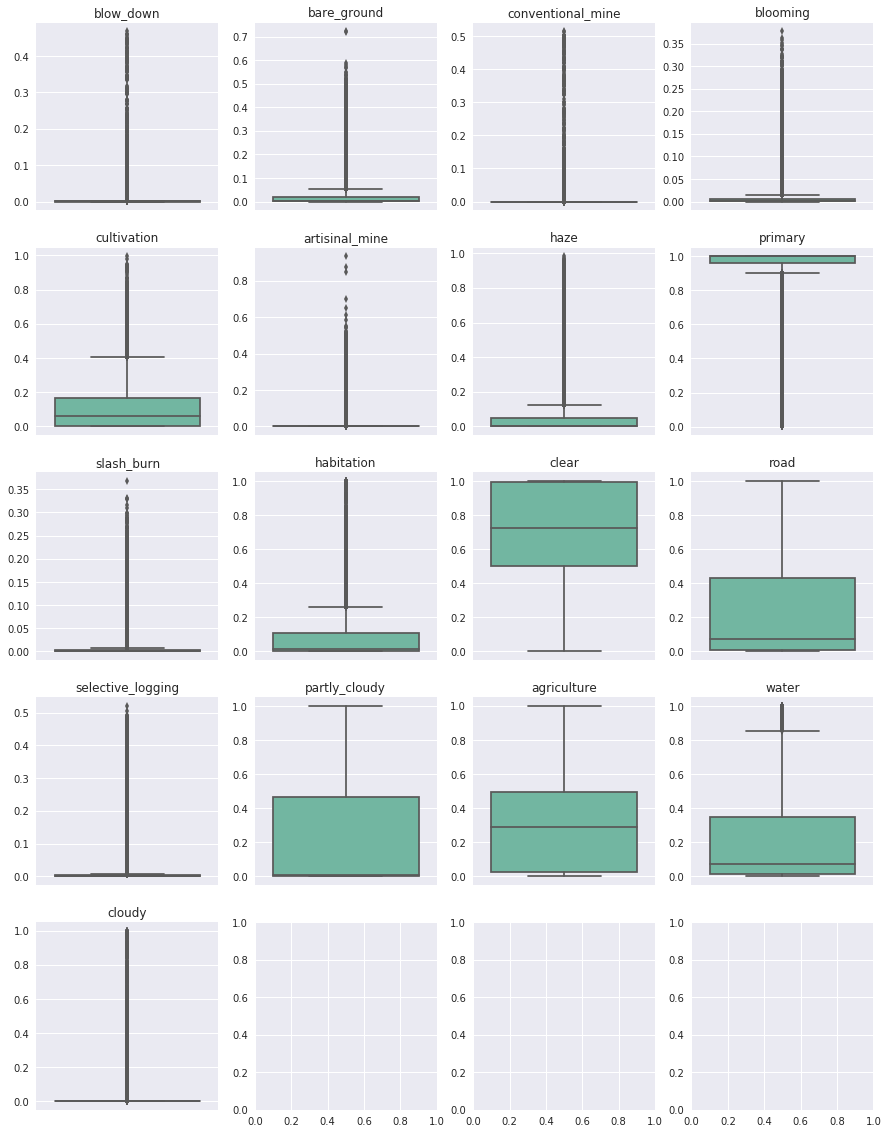

In [91]:
import seaborn as sns
tags_pred = np.array(preds).T
_, axs = plt.subplots(5, 4, figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    sns.boxplot(tag_vals, orient='v', palette='Set2', ax=axs[i]).set_title(labels[i])


In [9]:
label_preds = []
for i in tqdm_notebook(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > thres, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    label_preds.append(' '.join(list(a.index)))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
df_test["tags"] = label_preds
df_test.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,cultivation primary clear agriculture
4,test_4,primary partly_cloudy cloudy


In [11]:
df_test.head(100)

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,cultivation primary clear agriculture
4,test_4,primary partly_cloudy cloudy
5,test_5,primary clear
6,test_6,cultivation primary habitation clear agriculture
7,test_7,primary habitation clear road
8,test_8,primary clear
9,test_9,cultivation haze primary clear agriculture


In [12]:
submission_file = 'resnet_full_224x224_ft4a_10xtta_pseudo_fullset_2epochsvalid.csv'
df_test.to_csv(submission_file, index=False)
FileLink(submission_file)

/home/ubuntu/planet/resnet_full_224x224_ft4a_10xtta_pseudo_fullset_2epochsvalid.csv